# **Table of Contents**
* [Explore & Wrangle](#section_20)
* [Assumptions Testing](#section_21)

* [Model Building](#section_22)
    * [LiR](#section_23)
    * [RF](#section_24)
    <br><br>
* [Model Selection](#section_25)
    * [Fitting](#section_26)
    * [Validation](#section_27)
    * [Best Model](#section_28)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import warnings
warnings.filterwarnings("ignore")


from   sklearn.linear_model     import   LinearRegression
from   sklearn.ensemble         import   RandomForestRegressor

from   sklearn.model_selection  import   train_test_split , KFold , cross_val_score , GridSearchCV
from   sklearn.metrics          import   mean_squared_error

<a id='section_20'></a>
# Part 1 - **Explore & Wrangle**

In [2]:
df  =  pd.read_csv ('datasets/Car Sell Price.csv')

df.sample(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
75,etios g,2015,3.95,6.80,36000,Petrol,Dealer,Manual,0
294,amaze,2014,3.75,6.80,33019,Petrol,Dealer,Manual,0
80,corolla altis,2016,14.73,14.89,23000,Diesel,Dealer,Manual,0
184,Bajaj Pulsar 150,2008,0.25,0.75,26000,Petrol,Individual,Manual,1


**Target Col -- Selling_Price**

In [3]:
df.drop ( ['Car_Name','Year'] , axis=1 , inplace=True )

In [4]:
df ['Fuel_Type'].value_counts()

Petrol    239
Diesel     60
CNG         2
Name: Fuel_Type, dtype: int64

In [5]:
df.drop ( df [ df.Fuel_Type == 'CNG'].index , inplace=True )

In [6]:
df.shape

(299, 7)

In [7]:
df.isnull().sum()

Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [8]:
df = pd.get_dummies (df , drop_first=True)

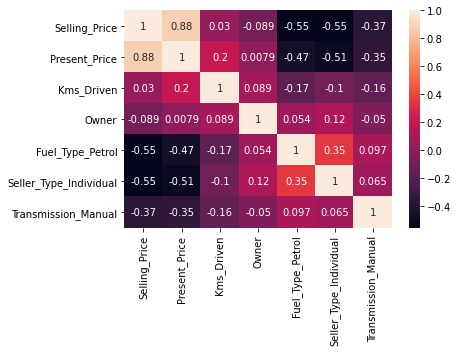

In [9]:
sns.heatmap ( df.corr() , annot=True ) ;

In [10]:
df.drop ( ['Kms_Driven' , 'Owner'] , axis=1 , inplace=True )

<a id='section_21'></a>
# Part 2 - **Assumption Testing**

In [11]:
import statsmodels.api as sm

y  =  df['Selling_Price']
x  =  df.drop('Selling_Price', axis=1)
xc =  sm.add_constant(x)

model = sm.OLS(y,xc).fit()

## **1. Normality of residuals**

In [12]:
residuals  =  model.resid

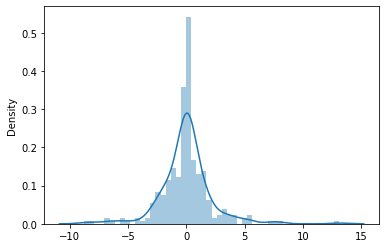

In [13]:
sns.distplot (residuals) ;

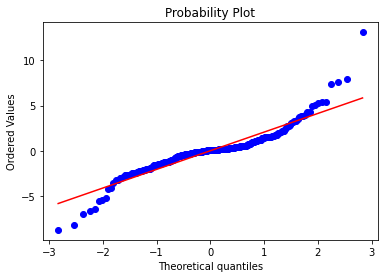

In [14]:
import scipy.stats as stats

stats.probplot (residuals ,  plot=plt)
plt.show()

In [15]:
stats.jarque_bera (residuals)

(583.8289452766342, 0.0)

>Comments :

        * test statistic , p-value
        * Residuals not normal
        * To achieve normal dist of residuals , apply boxcox transformation on target col.

In [16]:
df ['Selling_Price']  , lmb   =   stats.boxcox ( df ['Selling_Price'] )   

## **2. Low Multi-collinearity**

In [17]:
from   statsmodels.stats.outliers_influence   import   variance_inflation_factor   as   vif

score  =  [   vif (xc.values, i)        for i in  range(xc.shape[1])     ]

MC     =  pd.DataFrame (  {'VIF':score}  ,   index = xc.columns  )

MC.sort_values (by='VIF',ascending=False)

,VIF
const,22.114783
Present_Price,1.805714
Seller_Type_Individual,1.412711
Fuel_Type_Petrol,1.322081
Transmission_Manual,1.166085


## **3. Homo-scedasticity**

In [18]:
import statsmodels.stats.api as sms

sms.het_goldfeldquandt ( y=residuals , x=xc )

(0.1976482340645253, 0.9999999999999999, 'increasing')

> Comments :
        
        * H0 : Equal var of residuals
        * H1 : Unequal var of residuals 
        * Output : test_statistic , p-value 
> Obs :
        
        * P > alpha
        * Accept Null
        * Homo-scedastic

## **4. No Auto-correlation**

In [19]:
from  statsmodels.stats.stattools  import  durbin_watson

durbin_watson (residuals)

1.749360037504839

* Obs
    - Low auto-corr

## **5. Linearity**

In [20]:
import statsmodels.stats.api  as  sms

sms.diagnostic.linear_rainbow (model)

(142.73179224730416, 8.698747124010734e-115)

> Comments :
        
        * H0 : Reg is Linear
        * H1 : Reg is not Linear.
        * Output : test_statistic , p-value 
> Obs :
        
        * P < alpha
        * Reject Null
        * Reg is not Linear

<a id='section_22'></a>
# Part 3 - **Model Building**

In [21]:
x  =  df.drop ('Selling_Price' , axis=1)
y  =  df ['Selling_Price']

x_train , x_test , y_train , y_test   =   train_test_split (x, y, test_size=0.3, random_state=42)

<a id='section_23'></a>
## **1 - LiR**

In [22]:
lr = LinearRegression()                                       

lr.fit (x_train , y_train)             

LinearRegression()

<a id='section_24'></a>
## **2 - RF**

In [23]:
kf  =  KFold ( n_splits =3 ,  shuffle =True ,  random_state =42 )

In [24]:
RF    =  RandomForestRegressor()

param =  { 'n_estimators':np.arange(1,10) , 'max_depth':np.arange(1,10) }

GS    =  GridSearchCV (RF , param , cv=kf , scoring='r2')

GS.fit (x_train , y_train)

GS.best_params_

{'max_depth': 6, 'n_estimators': 3}

In [25]:
RF = RandomForestRegressor ( n_estimators=3 , max_depth =6 , random_state=0)  

RF.fit (x_train , y_train)

RandomForestRegressor(max_depth=6, n_estimators=3, random_state=0)

<a id='section_25'></a>
# Part 4 - **Model Selection**

In [26]:
models = []

models.append  (( 'LiR'     ,  lr      ))
models.append  (( 'RF'      ,  RF      ))

<a id='section_26'></a>
### **Fitting**

In [27]:
result = []

for i,j in models:

    print(i)
    
    y_train_pred  =  j.predict (x_train)
    y_test_pred   =  j.predict (x_test)
                   
    print  (  ( mean_squared_error  ( y_train , y_train_pred )) **0.5    )                                 
    print  (  ( mean_squared_error  ( y_test  , y_test_pred  )) **0.5    )

LiR
0.5035407768123126
0.8737509605158701
RF
0.33034802048379935
0.5135084089714064


<a id='section_27'></a>
### **Validation**

In [28]:
result = []

for  i,j  in  models:
    
    score = cross_val_score ( j , x_train , y_train , cv =kf, scoring ='r2' )
    
    result.append ( { 'Name': i   ,   'BE': np.mean(1-score)   ,   'VE': np.std(score,ddof=1)  } )                


table = pd.DataFrame(result)
table

,Name,BE,VE
0,LiR,0.133992,0.031725
1,RF,0.112439,0.018895


<a id='section_28'></a>
### **Best Model**

## *Random Forest Regressor*